# Part 3: Data Analysis (40%)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime 

import re
import nltk

## Step 1: Crawl a real-world dataset

In [98]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

sp = spotipy.Spotify(
    auth_manager=SpotifyClientCredentials(
        client_id='262f1d55233c40938cb157f5f2a45beb',
        client_secret='5ec6a7c82c1e402294f64217d662f58f'
    )
)

In [152]:
new_releases = sp.new_releases(
    country = 'GB',
    limit = 50
)

nr_next_50 = sp.new_releases(country= 'GB', limit = 50, offset = 50)
new_releases['albums']['items'].extend(nr_next_50['albums']['items'])

In [153]:
def get_ablum_uri_and_names(nr_data):
    album_names = []
    album_uri = []

    for i in nr_data['albums']['items']:
        album_uri.append(i['uri'])
        album_names.append(i['name'])

    return (album_names, album_uri)

In [154]:
nr_album_names, nr_album_uri = get_ablum_uri_and_names(new_releases)

In [156]:
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
track_info_features = ['artist', 'name', 'id', 'uri', 'duration_ms', 'explicit', 'track_number']
additional_features = ['album', 'popularity']

In [157]:
def get_song_info(uri, album_name):
    track_info = {}
    for k in additional_features + track_info_features + audio_features :
        track_info[k] = []

    album_tracks = sp.album_tracks(uri)['items']

    for i in album_tracks:
        for k in additional_features+ track_info_features:
            if k == 'album':
                track_info[k].append(album_name)
            elif k == 'popularity':
                track_info[k].append(sp.track(i['uri'])['popularity'])
            elif k == 'artist':
                track_info[k].append(i['artists'][0]['name'])
            else:
                track_info[k].append(i[k])

        audio = sp.audio_features(i['uri'])[0]

        for k in audio_features:
            if audio is None:
                track_info[k].append(None)
            else:
                track_info[k].append(audio[k])

    return track_info

In [158]:
nr_album_songs = {}
for k in additional_features + track_info_features + audio_features:
        nr_album_songs[k] = []

for uri, name in zip(nr_album_uri, nr_album_names):
    album_info = get_song_info(uri, name)
    for k, v in album_info.items():
        nr_album_songs[k] += v
    print(f'Songs from "{name}" have been added to dictionary.')
print(f'--- Done! {len(nr_album_names)} Albums added ---')

Songs from "i wonder if you wonder" have been added to dictionary.
Songs from "white light" have been added to dictionary.
Songs from "18 & Over" have been added to dictionary.
Songs from "Knebworth 1996 (Live)" have been added to dictionary.
Songs from "Goldmine (Deluxe)" have been added to dictionary.
Songs from "30" have been added to dictionary.
Songs from "Home Alone 2" have been added to dictionary.
Songs from "Actual Life 2 (February 2 - October 15 2021)" have been added to dictionary.
Songs from "The Stars Beneath My Feet (2004 - 2021)" have been added to dictionary.
Songs from "They Got Amnesia" have been added to dictionary.
Songs from "Flying Dream 1" have been added to dictionary.
Songs from "Between Us (Deluxe Version)" have been added to dictionary.
Songs from "The Nearer The Fountain, More Pure The Stream Flows" have been added to dictionary.
Songs from "CRAWLER" have been added to dictionary.
Songs from "An Evening With Silk Sonic" have been added to dictionary.
Songs f

In [159]:
data = pd.DataFrame.from_dict(nr_album_songs)

## Step 2: Perform data preparation & cleaning

In [160]:
# data shape
data.shape

(1296, 18)

In [161]:
data.columns

Index(['album', 'popularity', 'artist', 'name', 'id', 'uri', 'duration_ms',
       'explicit', 'track_number', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo'],
      dtype='object')

In [162]:
# Null value counts
data.isnull().sum(axis=0)

album               0
popularity          0
artist              0
name                0
id                  0
uri                 0
duration_ms         0
explicit            0
track_number        0
danceability        3
energy              3
loudness            3
speechiness         3
acousticness        3
instrumentalness    3
liveness            3
valence             3
tempo               3
dtype: int64

No major missing values. Some of the audio features have 2 missing, but we expect that to just be two erroneous songs.

Would either look to imputing with album mean or excluding. Both appropriate due to few cases.

In [163]:
# Drop un-needed columns
data.drop(
    columns = ['id', 'uri'],
    axis=1,
    inplace=True
)

In [164]:
# Imputer 'MISSING' into missing values
data.dropna(
    axis=0,
    inplace=True
)

In [165]:
# Normalise popularity (/100) and duration_ms to 0/1
def min_max_normalise(col):
    return (col - col.min()) / (col.max() - col.min())

data['popularity'] = data.popularity / 100
data['duration'] = min_max_normalise(data.duration_ms)
data['tempo'] = min_max_normalise(data.tempo)
data['loudness'] = min_max_normalise(data.loudness)

In [166]:
# Get album length from value_counts
data['album_length'] = data.album.map(data.album.value_counts().to_dict())

In [167]:
# New feature to mark if song is in the first half of the album or not
data['song_in_first_half'] = np.where(round(data.track_number / data.album_length) < 0.5, True, False)

In [168]:
data.dtypes

album                  object
popularity            float64
artist                 object
name                   object
duration_ms             int64
explicit                 bool
track_number            int64
danceability          float64
energy                float64
loudness              float64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
duration              float64
album_length            int64
song_in_first_half       bool
dtype: object

In [169]:
text_cols = ['album', 'name']

In [170]:
def average_word_length(row):
    return sum(map(len, row)) / len(row)

def remove_special_characters(row):
    out = re.sub(r'[^a-zA-Z0-9\s]', '', row)
    if len(out) == 0:
        return row
    else:
        return out

def get_tokenize(row):
    return nltk.word_tokenize(row)
    

In [171]:
for i in text_cols:
    data[i] = data[i].str.lower()

    data[i + '_rsc'] = data[i].apply(lambda x: remove_special_characters(x))

    data[i + '_tokenize'] = data[i + '_rsc'].apply(lambda x: get_tokenize(x))

    data[i + '_word_count'] = data[i + '_tokenize'].apply(lambda x: len(x))

    data[i + '_av_word_len'] = data[i + '_tokenize'].apply(lambda x: average_word_length(x))

In [172]:
# Drop columns that are not needed
data_out = data.drop(
    columns=['album_tokenize', 'name_tokenize', 'album_rsc', 'name_rsc', 'duration_ms', 'track_number'],
    axis=1
)

# Rename album and name columns to make them more explainable
data_out.rename(
    columns={'album': 'album_name', 'name' : 'song_name'},
    inplace=True
)

data_out.head()

,album_name,popularity,artist,song_name,explicit,danceability,energy,loudness,speechiness,acousticness,...,liveness,valence,tempo,duration,album_length,song_in_first_half,album_word_count,album_av_word_len,name_word_count,name_av_word_len
0,i wonder if you wonder,0.45,Grace Davies,somebody,False,0.401,0.432,0.788503,0.0343,0.611,...,0.101,0.3690,0.253910,0.281447,6,True,5,3.6,1,8.0
1,i wonder if you wonder,0.33,Grace Davies,i met a boy online,False,0.386,0.353,0.763833,0.0375,0.715,...,0.108,0.2970,0.470315,0.239233,6,True,5,3.6,5,2.8
2,i wonder if you wonder,0.33,Grace Davies,roots,False,0.402,0.357,0.685244,0.0356,0.765,...,0.132,0.0591,0.304903,0.265753,6,True,5,3.6,1,5.0
3,i wonder if you wonder,0.32,Grace Davies,testosterone,False,0.435,0.353,0.753725,0.0469,0.841,...,0.109,0.3380,0.396498,0.233134,6,False,5,3.6,1,12.0
4,i wonder if you wonder,0.32,Grace Davies,used to you,False,0.387,0.487,0.794648,0.0483,0.228,...,0.247,0.4020,0.676571,0.257579,6,False,5,3.6,3,3.0


## Step 3: Perform exploratory analysis and ask questions

#### Variable Distributions

In [173]:
data_out.dtypes

album_name             object
popularity            float64
artist                 object
song_name              object
explicit                 bool
danceability          float64
energy                float64
loudness              float64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
duration              float64
album_length            int64
song_in_first_half       bool
album_word_count        int64
album_av_word_len     float64
name_word_count         int64
name_av_word_len      float64
dtype: object

In [174]:
object_vars = ['song_name', 'album_name', 'artist']

numerical_vars = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'duration', 'album_length', 'album_word_count', 'album_av_word_len',
    'name_word_count', 'name_av_word_len']

bool_vars = ['explicit', 'song_in_first_half']

ignore_vars = []

In [175]:
all_vars = object_vars + numerical_vars + bool_vars + ignore_vars

print('All vars:', len(all_vars))
print('data vars:', len(data_out.columns))

All vars: 21
data vars: 21


#### Numerical Vars

In [176]:
numeric_df = data_out[numerical_vars]

numeric_summary = pd.concat(
    [
        numeric_df.count().rename('Count'),
        numeric_df.isnull().sum().rename('Null'),
        numeric_df.nunique().rename('Unique'),
        numeric_df.mean().round(3).rename('Mean'),
        numeric_df.median().round(3).rename('Median'),
        numeric_df.min().round(3).rename('Min'),
        numeric_df.max().round(3).rename('Max'),
        (numeric_df.max() - numeric_df.min()).round(3).rename('Range'),
    ],
    axis=1
)

numeric_summary

,Count,Null,Unique,Mean,Median,Min,Max,Range
popularity,1293,0,83,0.492,0.480,0.000,1.000,1.000
danceability,1293,0,576,0.593,0.605,0.072,0.981,0.909
energy,1293,0,637,0.617,0.637,0.033,0.989,0.956
loudness,1293,0,1211,0.804,0.825,0.000,1.000,1.000
speechiness,1293,0,707,0.114,0.058,0.023,0.929,0.906
acousticness,1293,0,969,0.301,0.181,0.000,0.995,0.995
instrumentalness,1293,0,791,0.084,0.000,0.000,0.990,0.990
liveness,1293,0,569,0.193,0.125,0.023,0.985,0.962
valence,1293,0,687,0.454,0.444,0.018,0.967,0.948
tempo,1293,0,1262,0.464,0.464,0.000,1.000,1.000


#### Distributions

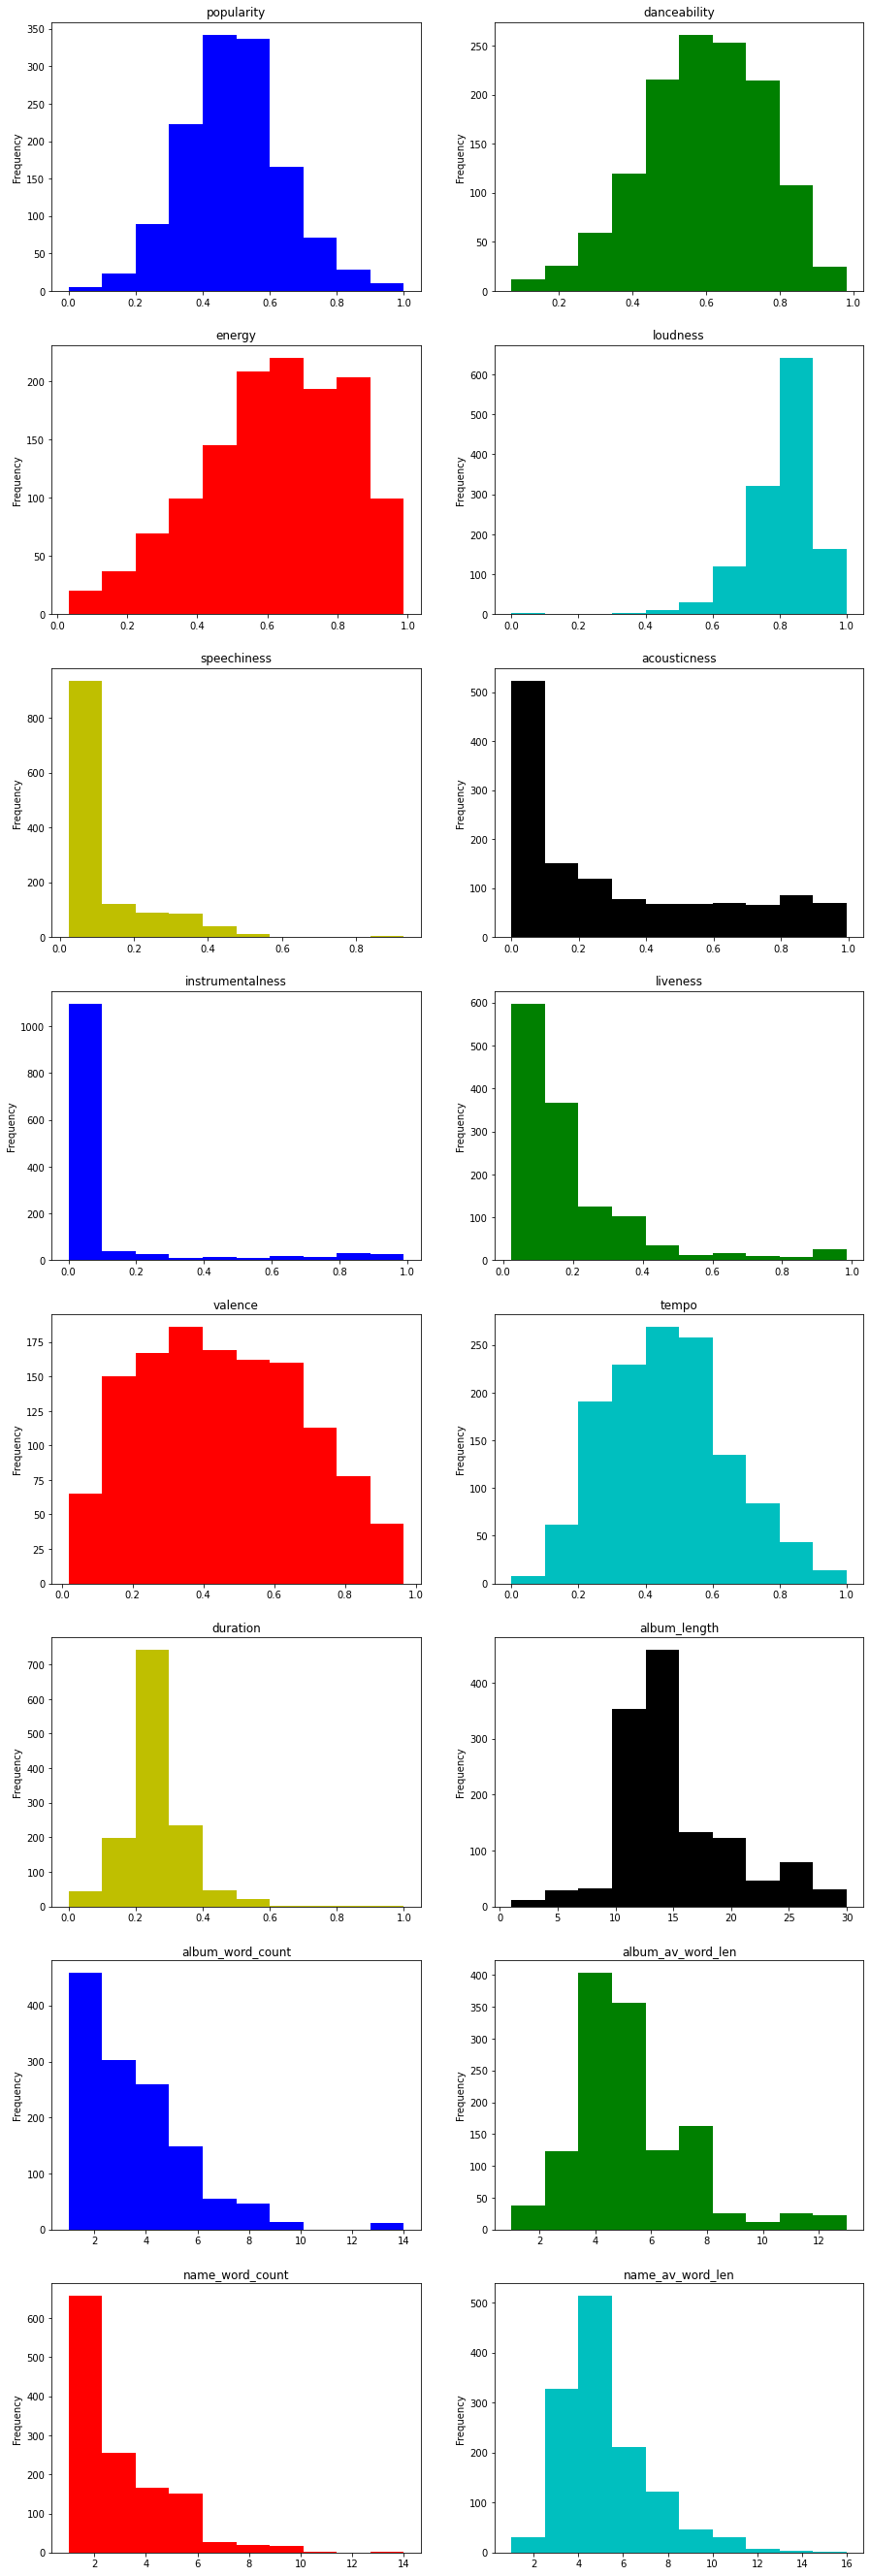

In [177]:
fig, ax = plt.subplots(
    nrows = (numeric_df.shape[1] // 2),
    ncols = 2,
    figsize = (15, 3 * numeric_df.shape[1])
)

colors = 'bgrcyk' * 3

for idx, col in enumerate(numeric_df.columns):
    x, y = idx // 2, idx % 2
    numeric_df[col].plot(
        ax = ax[x,y],
        kind = 'hist',
        color = colors[idx],
        legend = False,
        title = col
    )

plt.show()

#### Correlations

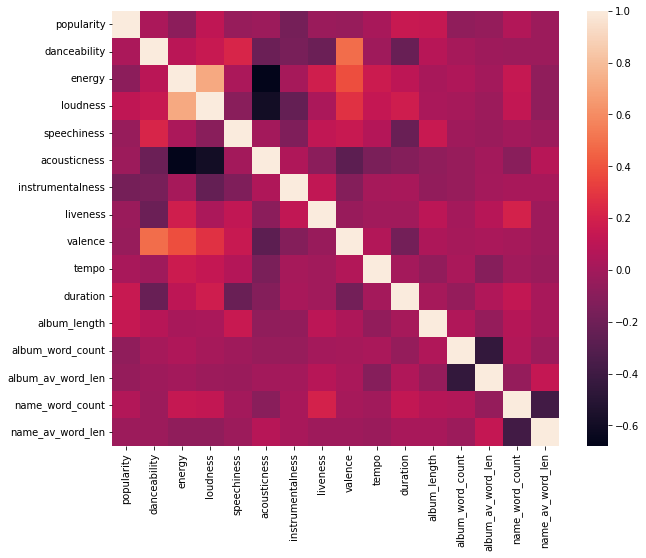

In [178]:
corr = data_out[numerical_vars].corr()

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax = ax)

plt.show()

#### Bool Vars

In [179]:
bool_df = data_out[bool_vars]

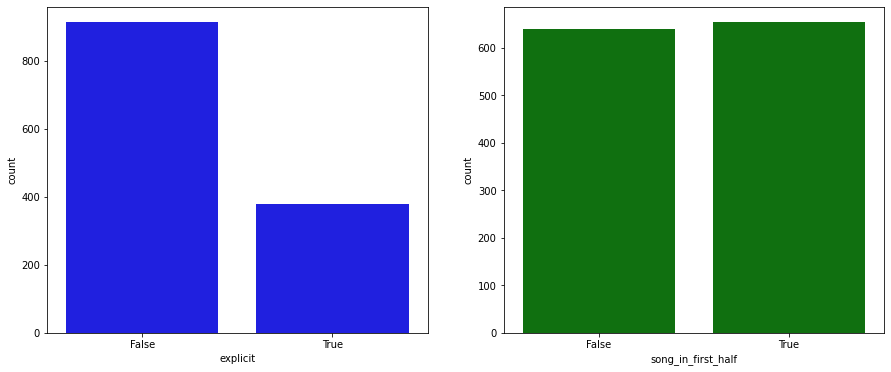

In [180]:
fig, ax = plt.subplots(
    nrows = (bool_df.shape[1] // 2),
    ncols = 2,
    figsize = (15, 3 * bool_df.shape[1])

)
colors = 'bg'

for idx, col in enumerate(bool_df.columns):
    sns.countplot(
        ax = ax[idx],
        data = bool_df,
        x = col,
        color = colors[idx]
    )

plt.show()

#### Boolean Correlation with Numeric Vars

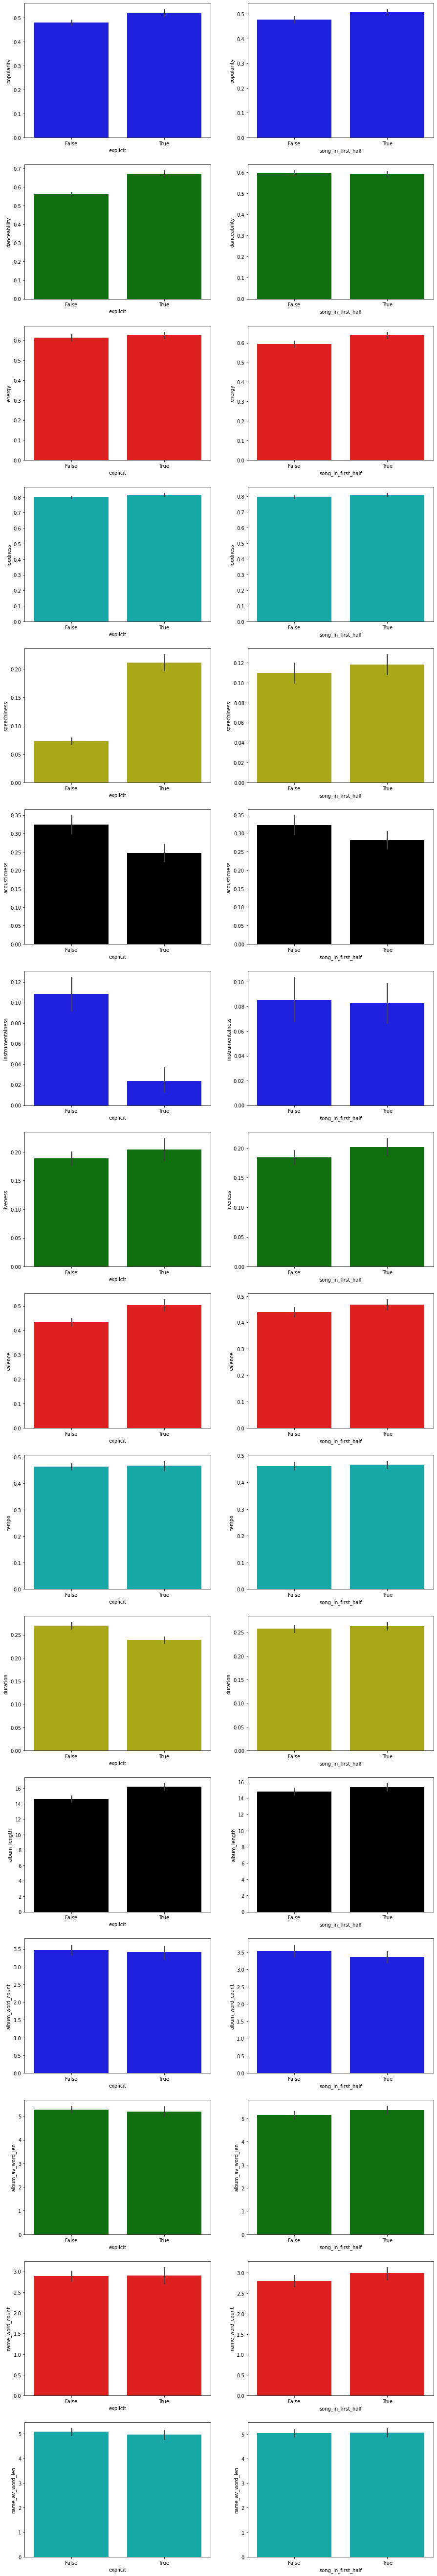

In [181]:
fig, ax = plt.subplots(
    nrows = numeric_df.shape[1],
    ncols = 2,
    figsize = (15, 6 * numeric_df.shape[1])
)

colors = 'bgrcyk' * 3

for idx, ncol in enumerate(numeric_df.columns):
    for idy, bcol in enumerate(bool_df.columns):
        sns.barplot(
            ax = ax[idx, idy],
            data = data_out,
            x = bcol,
            y = ncol,
            color = colors[idx]
        )

plt.show()

## Step 5: Summarise and write a conclusion using markdown cells